In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as op
import torch.nn.functional as F
from torchvision import transforms, datasets, utils  #torchvision.utils : 이미지데이터를 저장하고 시각화하기 위한 도구들이 있음
from torch.utils import data

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [0]:
epochs = 30
batch_size = 16

###torchvision transforms에서 자주 쓰이는 기능

*   ToTensor : 이미지를 텐서로
*   Resize : 이미지 리사이즈

*   Normalize : 주어진 평균과 표준편차를 이용하여 정규화
*   RandomHorizantalFlip : 무작위로 이미지의 오른쪽과 왼쪽을 뒤집는 기능

*   RandomCrop : 이미지를 무작위로 자르는 기능







In [0]:
#이미지를 텐서로 
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
])

In [6]:
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transform
)
testset = datasets.FashionMNIST(
    root = './.data/',
    train = False,
    download = True,
    transform = transform
)


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw
Processing...
Done!


##torch.utils.data.DataLoader : 데이터셋을 배치단위로 쪼개고 학습시 반복문 안에서 데이터를 공급

In [0]:
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = testset,
    batch_size = batch_size,
    shuffle = True
)

##데이터 뽑아서 보기
iter()를 이용해 반복문 안에서 이용할 수 있도록 만들고,



next()를 이용해 배치 1개를 가져온다.




배치 1개의 images, labels는 앞서 설정한 batch_size 만큼 이미지 16개와 라벨 16개가 들어간다.



In [0]:
images, labels = next(iter(train_loader))

torchvision의 utils.make_grid()를 이용하면 여러 이미지를 모아 하나의 이미지로 만들 수 있다.

> 들여쓴 블록
이 때 img 는 파이토치 텐서이기 때문에 matplotlib과 호환이 되는 넘파이 행렬로 바꿔야 한다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


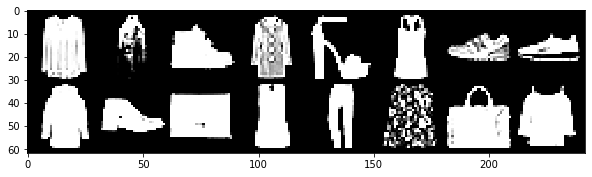

In [9]:
img = utils.make_grid(images)
npimg = img.numpy()
plt.figure(figsize = (10,7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [0]:
class Net(nn.Module):
  def __init__(self, drop_p = 0.2):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(784,256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128, 10)
    self.drop_p = drop_p
  def forward(self, x):
    x = x.view(-1,784)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.dropout(x, training = self.training, p = self.drop_p)
    x = self.fc3(x)
    return x
  

In [0]:
model = Net(drop_p = 0.2).to(device) # to함수로 모델 선언과 동시에 연산 수행 위치지정

In [0]:
optimizer = op.SGD(model.parameters(), lr = 0.01)

In [0]:
def train(model, train_loader, optimizer):  
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)  # 학습데이터를 device 메모리로 보냄
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()

In [0]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)

      test_loss += F.cross_entropy(output, target, reduction ='sum').item() 
      pred = output.max(1, keepdim = True)[1] # output.max()는 가장 큰 값과 그 값의 인덱스를 반환하는데 우리는 인덱스가 필요
      correct += pred.eq(target.view_as(pred)).sum().item() # eq()는 값이 일치하면 1, 아니면 0을 반환, sum()을 이용해서 현재 배치에서 모델이 정답을 맞힌 개수를 구한다.

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy    

In [21]:
for epoch in range(1, epochs + 1):
  train(model, train_loader, optimizer)
  test_loss, test_accuracy = evaluate(model, test_loader)

  print('[{}] Test Loss : {:.4f}, Accuracy : {:.2f}%'.format(epoch, test_loss, test_accuracy))

[1] Test Loss : 0.4671, Accuracy : 83.28%
[2] Test Loss : 0.4137, Accuracy : 85.11%
[3] Test Loss : 0.3983, Accuracy : 85.63%
[4] Test Loss : 0.3830, Accuracy : 86.08%
[5] Test Loss : 0.3641, Accuracy : 87.05%
[6] Test Loss : 0.3666, Accuracy : 86.88%
[7] Test Loss : 0.3554, Accuracy : 87.10%
[8] Test Loss : 0.3521, Accuracy : 86.97%
[9] Test Loss : 0.3476, Accuracy : 87.28%
[10] Test Loss : 0.3434, Accuracy : 87.63%
[11] Test Loss : 0.3372, Accuracy : 87.65%
[12] Test Loss : 0.3407, Accuracy : 87.74%
[13] Test Loss : 0.3235, Accuracy : 88.48%
[14] Test Loss : 0.3397, Accuracy : 87.61%
[15] Test Loss : 0.3343, Accuracy : 88.23%
[16] Test Loss : 0.3301, Accuracy : 88.34%
[17] Test Loss : 0.3322, Accuracy : 87.98%
[18] Test Loss : 0.3166, Accuracy : 88.58%
[19] Test Loss : 0.3275, Accuracy : 88.08%
[20] Test Loss : 0.3531, Accuracy : 87.37%
[21] Test Loss : 0.3208, Accuracy : 88.79%
[22] Test Loss : 0.3142, Accuracy : 89.19%
[23] Test Loss : 0.3216, Accuracy : 88.79%
[24] Test Loss : 0.3